In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import timeit
import time

<h1>Load training, validation, testing set from your preprocessed files</h1>

In [2]:
for i in range(5):
    with open('dogs-vs-cats-train-image-'+str(i)+'.pickle', 'rb') as f:
        tmp = pickle.load(f)
        try:
            train_image = np.concatenate((train_image, tmp))
        except:
            train_image = tmp
    with open('dogs-vs-cats-train-label-'+str(i)+'.pickle', 'rb') as f:
        tmp = pickle.load(f)
        try:
            train_label = np.concatenate((train_label, tmp))
        except:
            train_label = tmp
with open('dogs-vs-cats-val-image.pickle', 'rb') as f:
    val_image = pickle.load(f)
with open('dogs-vs-cats-val-label.pickle', 'rb') as f:
    val_label = pickle.load(f)
for i in range(3):
    with open('dogs-vs-cats-test-image-'+str(i)+'.pickle', 'rb') as f:
        tmp = pickle.load(f)
        try:
            test_image = np.concatenate((test_image, tmp))
        except:
            test_image = tmp
print(train_image.shape)
print(val_image.shape)
print(test_image.shape)
print(train_label.shape)
print(val_label.shape)

(24500, 227, 227, 3)
(500, 227, 227, 3)
(12500, 227, 227, 3)
(24500, 2)
(500, 2)


<h1>Define hyperparameter</h1>

In [3]:
lr = 0.0001
epochs = 10
batch_size = 128
dropout = 0.5
num_classes = 2
W = 227
H = 227
channel = 3

<h1>Placeholder</h1>

In [4]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,[None, W, H, channel], name='X')
Y = tf.placeholder(tf.int32,[None, num_classes], name='Y')
training = tf.placeholder_with_default(False, shape=())

<h1>AlexNet</h1>

In [5]:
def AlexNet(x):
    conv1_out = tf.layers.conv2d(x, 96, 11, 4, 'valid', activation=tf.nn.relu)
    maxPool1_out = tf.contrib.layers.max_pool2d(conv1_out, 3, 2, 'VALID')
    out1 = tf.nn.lrn(maxPool1_out)
    
    conv2_out = tf.layers.conv2d(out1, 256, 5, 1, 'same', activation=tf.nn.relu)
    maxPool2_out = tf.contrib.layers.max_pool2d(conv2_out, 3, 2, 'VALID')
    out2 = tf.nn.lrn(maxPool2_out)

    out3 = tf.layers.conv2d(out2, 384, 3, 1, 'same', activation=tf.nn.relu)
    
    out4 = tf.layers.conv2d(out3, 384, 3, 1, 'same', activation=tf.nn.relu)
    
    out5 = tf.layers.conv2d(out4, 256, 3, 1, 'same', activation=tf.nn.relu)    
    maxPool5_out = tf.contrib.layers.max_pool2d(out5, 3, 2, 'VALID')
    
    layer5_drop = tf.layers.dropout(maxPool5_out, dropout,  training=training)
    layer5_reshape = tf.reshape(layer5_drop, shape=[-1, 256 * 6 * 6])
    fc1 = tf.layers.dense(layer5_reshape, 512, activation=tf.nn.relu, use_bias=True)
    fc1_drop = tf.layers.dropout(fc1, dropout,  training=training)
    fc2 =  tf.layers.dense(fc1, 512, activation=tf.nn.relu, use_bias=True)
    logits = tf.layers.dense(fc2, 2, activation=tf.nn.softmax, use_bias=True)
    
    return logits

<h1>Cost and Optimization</h1>

In [6]:
logits = AlexNet(X)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

<h1>Training and validation</h1>
<h2>Train your model only 10 epochs</h2>
<p style="font-size:20px">1. Print out training accuracy and validation accuracy each training epoch</p>
<p style="font-size:20px">2. Print out training time each training epoch</p>
<p style="font-size:20px">3. Your goal is to reach 85% validation accuracy in 10 training epochs. If you reach that, you can perform testing, print out your test accuracy. Plot out the ten images with title that contains the probability of the labeled class.</p>

In [7]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0, data.shape[0])
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    data_shuffle = np.asarray(data_shuffle)
    labels_shuffle = np.asarray(labels_shuffle)
    labels_shuffle = np.squeeze(labels_shuffle)
    return data_shuffle, labels_shuffle

In [8]:
init = tf.global_variables_initializer()

total_batch = int(24500 / batch_size)

with tf.Session() as sess:
    sess.run(init)
    time_start = time.time()
    for i in range(epochs):
        for j in range(total_batch):
            batch_x, batch_y = next_batch(batch_size, train_image, train_label)
            sess.run(train_op, feed_dict={X:batch_x, Y:batch_y, training:True})
        time_end = time.time()
        l, acc = sess.run([loss, accuracy],feed_dict={X:batch_x, Y:batch_y})
        acc_val = sess.run(accuracy,feed_dict={X:val_image, Y:val_label})
        print("epoch " + str(i+1) + ", loss: {:.4f}".format(l) + ", acc: {:.4f}".format(acc) + ", acc_val: {:.4f}".format(acc_val) + \
              ", time: {:.3f}\t".format(time_end-time_start))
        time_start = time.time()
    pred_test = sess.run(logits, feed_dict = {X: test_image[:10]})

epoch 1, loss: 0.6234, acc: 0.6562, acc_val: 0.7100, time: 24.992	
epoch 2, loss: 0.5814, acc: 0.7188, acc_val: 0.7100, time: 23.548	
epoch 3, loss: 0.4835, acc: 0.8438, acc_val: 0.7720, time: 23.911	
epoch 4, loss: 0.5215, acc: 0.7891, acc_val: 0.7560, time: 23.728	
epoch 5, loss: 0.4867, acc: 0.8125, acc_val: 0.8200, time: 23.481	
epoch 6, loss: 0.4665, acc: 0.8359, acc_val: 0.8080, time: 23.505	
epoch 7, loss: 0.4638, acc: 0.8281, acc_val: 0.8520, time: 23.554	
epoch 8, loss: 0.4251, acc: 0.8750, acc_val: 0.8680, time: 23.589	
epoch 9, loss: 0.4039, acc: 0.9141, acc_val: 0.8760, time: 23.571	
epoch 10, loss: 0.3853, acc: 0.9375, acc_val: 0.8780, time: 23.558	


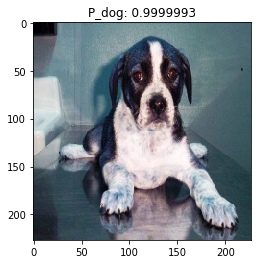

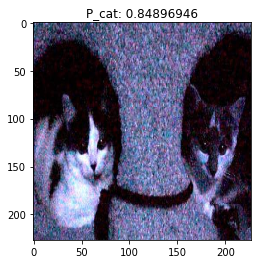

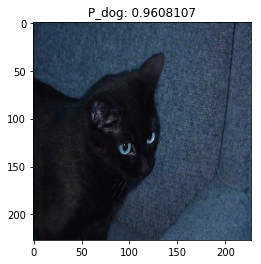

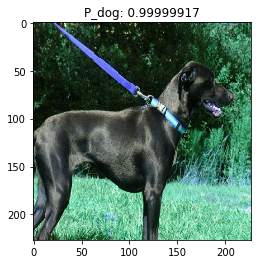

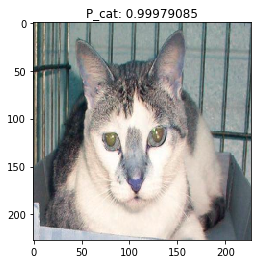

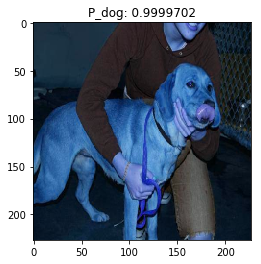

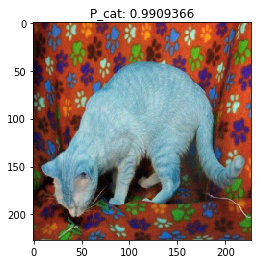

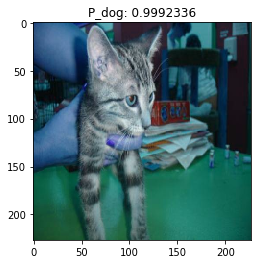

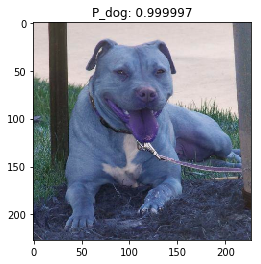

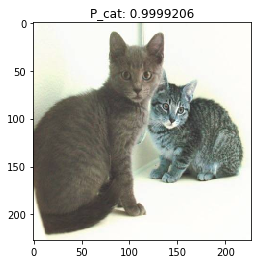

In [9]:
for i in range(10):
    pred = np.squeeze(pred_test[i])
    if pred[0] < pred[1]:
        result = "P_dog: "+str(pred[1])
    else:
        result = "P_cat: "+str(pred[0])
    fig = plt.figure()
    plt.imshow(np.squeeze(test_image[i]))
    plt.title(result)